# The Task at Hand

Have you ever wondered if computers could translate languages? Did you think google translate or duolingo worked because they memorized answers? 

The type of problem that translation solves is sequence to sequence. For instance, we could convert an english input sequence to a german output sequence. 

In this activity, we will create an english -> chinese translator and apply what we've been learning about LSTMs & RNNs.

## Preparing the data
We need to import our packages and data to learn a little bit about the problem at hand.

In [27]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Word2Sequence import Word2Sequence
from Dataset import Dataset
from Seq2Seq import Seq2Seq
help(Word2Sequence)

Help on class Word2Sequence in module Word2Sequence:

class Word2Sequence(builtins.object)
 |  Word2Sequence(custom_dict=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, custom_dict=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |      returns the number of words categorized (including special tokens)
 |  
 |  build_vocab(self, min=5, max=None, max_features=None)
 |      build self.dict and reverse_dict
 |      param min:          least occurrance of word to be considered
 |      param max:          max occurrance of word to be considered
 |      param max_features: max vocab size for tokenizer
 |      returns:
 |  
 |  fit(self, sentence)
 |      save words in sentence to self.dict
 |      param: sentence (1D List): [word1, word2, word3...]
 |  
 |  inverse_transform(self, indices, is_tensor=False)
 |      convert int sequences to string words
 |      param indices: [1, 2, 3, ...]
 |      returns: [word1, word2, word3..

In [28]:
# read small_en-cn.txt file
data_path = './eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist() #this will be all of the english sentences
target_texts = df.chinese.values.tolist() #this will be all of the chinese sentences
df.head()

,english,chinese
0,Does any other country fan the flames of patri...,有没有一个国家比美国更提倡爱国主义？
1,I always enjoy listening to classical music wh...,有空的时候，我总喜欢听古典音乐。
2,I was nine years old when I asked my mom if Sa...,我九岁的时候问我妈妈圣诞老人是否真的存在。
3,I'm a foreigner and I don't know Czech very we...,我是外国人，我捷克语不好，请说慢一点。
4,"If it's at all possible, I'd like you to take ...","如果可能的話, 我希望你參加下一次的會議。"


In [29]:
# Your code here: Try printing some english and chinese sentences from their lists input_texts and target_texts!
print(input_texts[4])
print(target_texts[7])


If it's at all possible, I'd like you to take part in the next meeting.
善良是聾子能聽盲人能看的語言。


In [30]:
#read in our model object. Tokenize our data
tk = WordPunctTokenizer()
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

In [31]:
# Your code here: Explore this data. Can you calculate the maximum length of a sequence in each dataset english and chinese?

# calculate max_len of any sequence in 'english' list and save it to a variable called max_english_length 
max_english_length = max([len(i) for i in english])
print(max_english_length)
# calculate max_len of any sequence in 'chinese' list and save it to a variable called max_chinese_length
max_chinese_length = max([len(i) for i in chinese])
print(max_chinese_length)

25
39


In [32]:
input_tokenizer = Word2Sequence()
for words in english:
    input_tokenizer.fit(words)
input_tokenizer.build_vocab(min=1, max_features=None) #inpu

output_tokenizer = Word2Sequence()
for words in chinese:
    output_tokenizer.fit(words)
output_tokenizer.build_vocab(min=1, max_features=None)


# Your code here: print the total english words in your input tokenizer and total chinese words in your output tokenizer below!

eng_words = input_tokenizer.dict
chin_words = output_tokenizer.dict

print(len(input_tokenizer))
print(len(output_tokenizer))
print(eng_words)
print(chin_words)

199
317
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'does': 4, 'any': 5, 'other': 6, 'country': 7, 'the': 8, 'of': 9, 'as': 10, 'much': 11, '?': 12, 'i': 13, 'always': 14, 'enjoy': 15, 'to': 16, 'when': 17, 'have': 18, 'some': 19, 'time': 20, '.': 21, 'was': 22, 'years': 23, 'asked': 24, 'my': 25, 'if': 26, 'really': 27, "'": 28, 'm': 29, 'a': 30, 'and': 31, 'don': 32, 't': 33, 'know': 34, 'very': 35, 'well': 36, ',': 37, 'speak': 38, 'it': 39, 's': 40, 'at': 41, 'all': 42, 'd': 43, 'like': 44, 'you': 45, 'take': 46, 'in': 47, 'next': 48, 'work': 49, 'do': 50, 'something': 51, 'more': 52, 'than': 53, 'money': 54, 'not': 55, 'until': 56, 'had': 57, 'myself': 58, 'that': 59, 'knew': 60, 'what': 61, 'mother': 62, 'love': 63, 'is': 64, 'language': 65, 'which': 66, 'can': 67, 'see': 68, 'mary': 69, 'came': 70, 'from': 71, 'school': 72, 'because': 73, 'her': 74, 'father': 75, 'no': 76, 'less': 77, 'me': 78, 'now': 79, 'whether': 80, 'want': 81, 'get': 82, 'or': 83, 'people': 84, 'up': 8

<h1>Creating the model</h1>

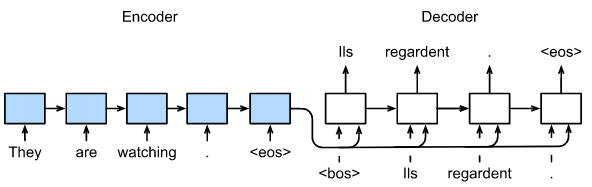

NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 

1. \<SOS>, word1, word2, word3, ..., \<EOS>
2. word1, word2, word3, ..., \<EOS> 
3. word1, word2, word3, ...

NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):

- Decoder Input: \<SOS>, word1, word2, word3, ...
- Decoder Output: word1, word2, word3, ..., \<EOS>  

This means that our input and ouput max length should be one more than the sequence's max length.

WHY? Data Structure:

- 1. Encoder Input: [word1, word2, ... + <EOS>]
- 2. Decoder Input: [<SOS> + word1, word2, ...]
- 3. Decoder Output:[word1, word2, ... + <EOS>]
    

nn docs - https://pytorch.org/docs/stable/nn.html



In [33]:
# Seq2Seq Parameters
in_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
out_maxlen = max_chinese_length + 1 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(input_tokenizer.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(output_tokenizer.dict) # OR... vocab size of chinese -> 317
batch_size = 1

In [34]:
eng_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
chin_maxlen = max_chinese_length + 1  # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 

# Setup the Dataset.
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = input_tokenizer, out_tknz = output_tokenizer,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)

'''
The following are helper functions to help pytorch. You won't need to know this much.
'''
# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    '''
    Returns a way to access and use the data
    '''
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)
dataloader = get_dataloader(dataset, batch_size)

In [35]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(input_tokenizer.dict),
    dec_n_class = len(output_tokenizer.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

/projects/aebc210b-e912-4df7-91ea-37e0f8451ece/miniconda3/envs/nlp_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [36]:
# Define Loss and Optimizer -- these are ways we define performance for our model. If you're curious: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

<h1>Training our model</h1>

In [44]:
'''
Your code here: change the number of epochs to see how it effects training time and quality
'''
epochs = 200


'''
Training -- no need to touch the code below.
'''
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []


for epoch in range(epochs):
    # runs the model and calculates loss
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)
        
        pred = model(enc_in, enc_h_0, dec_in)
        
        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)
    
    # runs the actual back propacation
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 12.239891052246094


Epoch: 10, Loss: 10.612025260925293


Epoch: 20, Loss: 9.206803321838379


Epoch: 30, Loss: 8.047005653381348


Epoch: 40, Loss: 7.094229698181152


Epoch: 50, Loss: 6.378555774688721


Epoch: 60, Loss: 5.614348888397217


Epoch: 70, Loss: 5.004857540130615


Epoch: 80, Loss: 4.523636817932129


Epoch: 90, Loss: 4.103368282318115


Epoch: 100, Loss: 3.704559803009033


Epoch: 110, Loss: 3.445056200027466


Epoch: 120, Loss: 3.9256134033203125


## Let's check out our model's progress
No need to change the code below, this will plot our loss over time. How do you think we can tweak our code to decrease loss even further?

In [1]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [2]:
showPlot([loss.cpu().item() for loss in loss_records])

NameError: name 'loss_records' is not defined

<h1>Code for Translating with our Model</h1>
This is where the Seq2Seq happens after the model is trained.


In [40]:
'''
No need to touch this code: 
'''

def translate(eng_sent, model, device):
    # set up the inputs and variables
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = input_tokenizer.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = output_tokenizer.transform(dec_in, max_len=out_maxlen, pad_first=False)
    
    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    # run the model
    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

# Using our Model in Practice
Check out these examples below. This is how you can translate sequences!

In [41]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

Tom did the best he could, but he wasn't able to get a higher grade than Mary. -> 
汤姆得出<UNK>论他做什么，玛丽都不会喜欢的结论。
Eighty percent of all information on computers around the world is in English. -> 
全世界百分之八十電<UNK>上的<UNK><UNK>都是用英語<UNK>的。
She visits the dentist on a regular basis, so she seldom gets toothaches. -> 
她定<UNK>去看牙<UNK>，所以她很少牙<UNK>。
His scores are always better than mine, even though he doesn't study very much. -> 
他的<UNK>物<UNK>给不足的的时候，他不得不去找新的地<UNK>居住。
If it looks like an apple and it tastes like an apple, it's probably an apple. -> 
如果看起来像个苹果而且吃起来也像苹果的话，可能就是苹果。


# Your turn!

Can you use the code in the cell above to translate custom sentences? 



In [42]:
'''
Your code here: translate custom sentences using the code above. Hint: You won't need a for loop!
'''

"\nYour code here: translate custom sentences using the code above. Hint: You won't need a for loop!\n"

In [43]:
translation = input("type english: ")
translated = translate(translation, model, torch.device("cpu"))
translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
print(f"{translation} -> \n{translated_sent}")

type english:  tom was visiting the dentist and then started to read with the lights on

tom was visiting the dentist and then started to read with the lights on -> 
<UNK><UNK>的感<UNK>。
